# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from datetime import datetime
from textblob import TextBlob

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

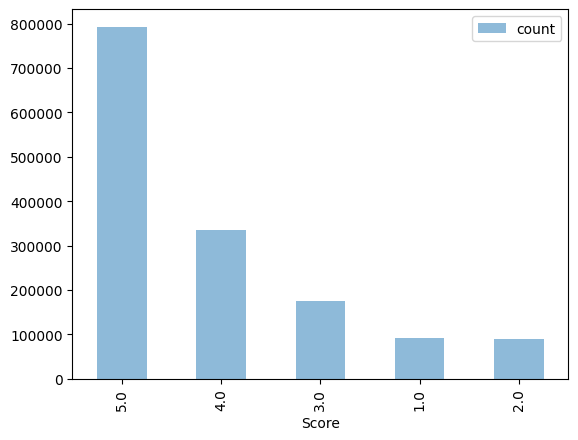


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    file_name = "./pickles/NumExclamation.pkl"
    if exists(file_name):
        df["NumExclamation"] = pd.read_pickle(file_name)
    else:
        ne = df["Text"].apply(lambda s: sum([1 for c in s if c == "!"]) if type(s) == str else 0)
        df["NumExclamation"] = ne
        ne.to_pickle(file_name)

    file_name = "./pickles/NumQuestion.pkl"
    if exists(file_name):
        df["NumQuestion"] = pd.read_pickle(file_name)
    else:
        nq = df["Text"].apply(lambda s: sum([1 for c in s if c == "?"]) if type(s) == str else 0)
        df["NumQuestion"] = nq
        nq.to_pickle(file_name)
    
    file_name = "./pickles/TextPolarity.pkl"
    if exists(file_name):
        df["TextPolarity"] = pd.read_pickle(file_name)
    else:
        tp = df["Text"].apply(lambda s: TextBlob(s).sentiment.polarity if type(s) == str else 0)
        df["TextPolarity"] = tp
        tp.to_pickle(file_name)

    file_name = "./pickles/SummaryPolarity.pkl"
    if exists(file_name):
        df["SummaryPolarity"] = pd.read_pickle(file_name)
    else:
        sp = df["Summary"].apply(lambda s: TextBlob(s).sentiment.polarity if type(s) == str else 0)
        df["SummaryPolarity"] = sp
        sp.to_pickle(file_name)

    file_name = "./pickles/TextSub.pkl"
    if exists(file_name):
        df["TextSub"] = pd.read_pickle(file_name)
    else:
        ts = df["Text"].apply(lambda s: TextBlob(s).sentiment.subjectivity if type(s) == str else 0)
        df["TextSub"] = ts
        ts.to_pickle(file_name)
    
    file_name = "./pickles/SummarySub.pkl"
    if exists(file_name):
        df["SummarySub"] = pd.read_pickle(file_name)
    else:
        ss = df["Summary"].apply(lambda s: TextBlob(s).sentiment.subjectivity if type(s) == str else 0)
        df["SummarySub"] = ss
        ss.to_pickle(file_name)

    # Magnify Polarity
    #df["TextPolarity"] = df["TextPolarity"] * 10
    #df["SummaryPolarity"] = df["SummaryPolarity"] * 10

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

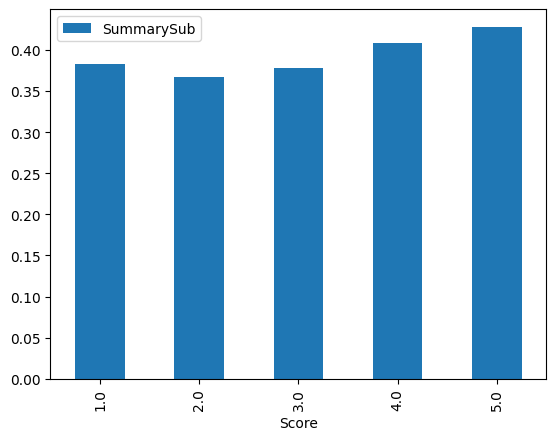

In [4]:
X_train[["Score", "SummarySub"]].groupby("Score").mean().plot(kind="bar")
plt.show()

In [5]:
X_train[["Score", "TextSub"]].groupby("Score").describe()

TextSub                                                            
          count      mean       std  min       25%       50%       75%  max
Score                                                                      
1.0     91190.0  0.528559  0.146948  0.0  0.454946  0.528646  0.605556  1.0
2.0     89678.0  0.520172  0.123292  0.0  0.455981  0.518178  0.583416  1.0
3.0    176082.0  0.514263  0.119492  0.0  0.450000  0.511692  0.576923  1.0
4.0    335228.0  0.526514  0.124272  0.0  0.457675  0.521712  0.592552  1.0
5.0    793163.0  0.550355  0.146692  0.0  0.468546  0.545357  0.630748  1.0

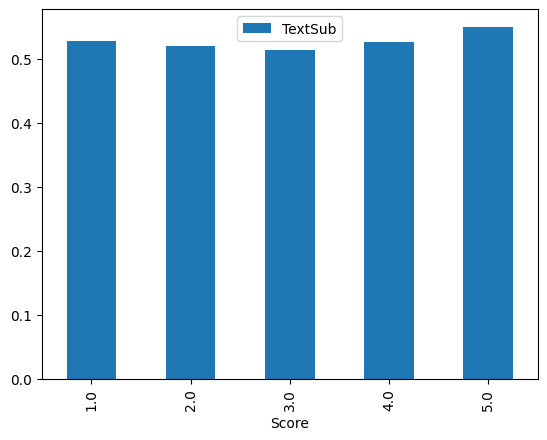

In [6]:
X_train[["Score", "TextSub"]].groupby("Score").mean().plot(kind="bar")
plt.show()

In [7]:
X_train.head(20)

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score,NumExclamation,NumQuestion,TextPolarity,SummaryPolarity,TextSub,SummarySub
0,914403,B0009W5KHM,AV6QDP8Q0ONK4,2,2,1341014400,GOOD FUN FILM,While most straight to DVD films are not worth...,5.0,0,0,0.168705,0.500000,0.456875,0.400000
1,354887,6303079709,A2I8RXJN80A2D2,0,0,1168819200,Movie Review,"I have wanted this one for sometime, also. I ...",5.0,0,0,0.400000,0.000000,0.500000,0.000000
2,1407653,B004H0M2XC,A3FHV3RV8Z12E6,0,0,1386201600,When is it a good time to Consent?,Actually this was a pretty darn good indie fil...,4.0,0,0,0.336364,0.700000,0.463636,0.600000
3,1377458,B003ZJ9536,A12VLTA3ZHVPUY,1,1,1348704000,TRUTH,Episodes 37 to 72 of the series press on in a ...,5.0,0,0,0.344697,0.000000,0.469823,0.000000
4,475323,630574453X,A13NM1PES9OXVN,2,3,970012800,Intelligent and bittersweet -- stays with you,"I was really impressed with this movie, but wa...",3.0,1,0,0.247796,0.800000,0.648886,0.900000
5,353326,6303049079,AI0OAQ6E2O8VF,7,8,974073600,DVD Edition Excellent Has deleted scenes which...,This DVD edition has over 30 minutes of delete...,5.0,3,0,0.102500,0.750000,0.473000,1.000000
6,20785,0767835980,A1JH5J1KQAUBMP,0,0,994550400,Interesting characters trapped in cliched circ...,Punk--at least as it is portrayed in the media...,3.0,0,0,0.182727,0.150000,0.539091,0.250000
7,161632,0800113055,AMMEMPM9MPS55,3,3,1048636800,Unparalleled romantic comedy,Frank Capra's It Happened One Night is a hilar...,5.0,0,0,0.334888,0.000000,0.701927,0.500000
8,1131507,B0011KQSWM,A3T0OTH5072YRE,0,0,1355702400,Law & Order SVU: Season Six,Law and Order SVU Season Six is exactly what t...,4.0,0,1,0.151646,0.000000,0.559473,0.000000
9,38793,0780631684,A3J845PJ4IG68M,2,4,1277683200,Final D - #1,this may not be the best of the FD's but it's ...,5.0,0,0,0.680000,0.000000,0.605000,1.000000


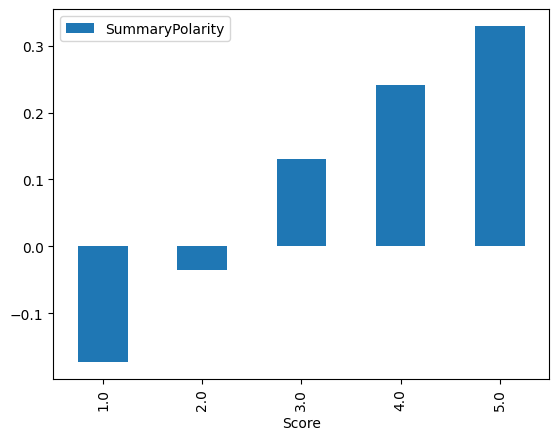

In [8]:
X_train[["Score", "SummaryPolarity"]].groupby("Score").mean().plot(kind="bar")
plt.show()

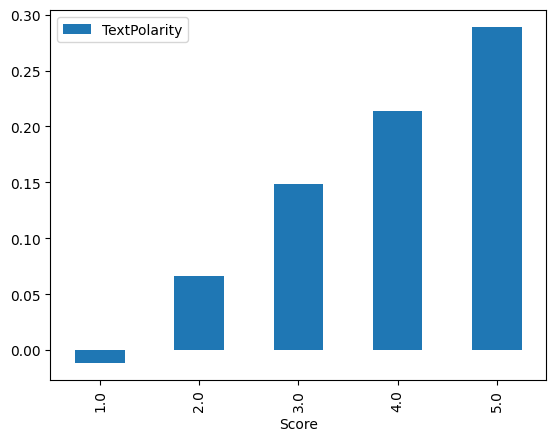

In [9]:
X_train[["Score", "TextPolarity"]].groupby("Score").mean().plot(kind="bar")
plt.show()

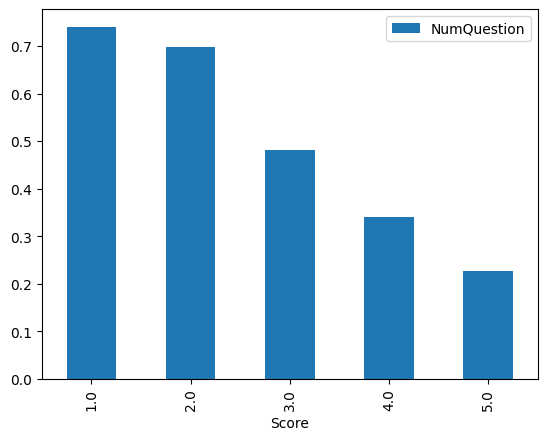

In [10]:
X_train[["Score", "NumQuestion"]].groupby("Score").mean().plot(kind="bar")
plt.show()

In [11]:
X_train[["Score", "NumQuestion"]].groupby("Score").describe()

NumQuestion                                               
            count      mean       std  min  25%  50%  75%    max
Score                                                           
1.0       91190.0  0.740586  1.997084  0.0  0.0  0.0  1.0   99.0
2.0       89678.0  0.698967  1.768740  0.0  0.0  0.0  1.0   55.0
3.0      176082.0  0.481827  1.377116  0.0  0.0  0.0  0.0   54.0
4.0      335228.0  0.339453  1.072916  0.0  0.0  0.0  0.0   80.0
5.0      793163.0  0.226232  0.876809  0.0  0.0  0.0  0.0  107.0

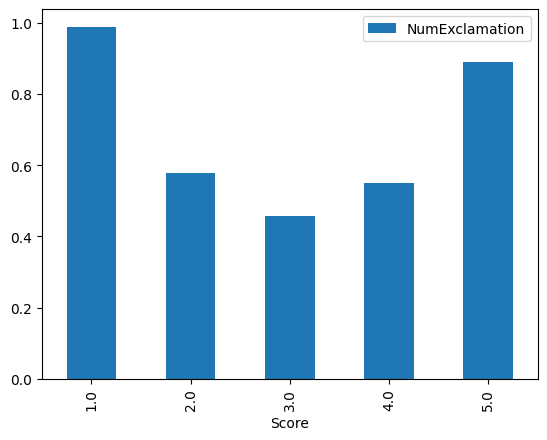

In [12]:
X_train[["Score", "NumExclamation"]].groupby("Score").mean().plot(kind="bar")
plt.show()

In [13]:
X_train[["Score", "NumExclamation"]].groupby("Score").describe()

NumExclamation                                               
               count      mean       std  min  25%  50%  75%    max
Score                                                              
1.0          91190.0  0.989067  2.930460  0.0  0.0  0.0  1.0  149.0
2.0          89678.0  0.579083  2.013139  0.0  0.0  0.0  0.0  166.0
3.0         176082.0  0.456793  1.595721  0.0  0.0  0.0  0.0  118.0
4.0         335228.0  0.550345  1.720946  0.0  0.0  0.0  0.0  177.0
5.0         793163.0  0.889489  2.584007  0.0  0.0  0.0  1.0  295.0

# Sample + Split into training and testing set

In [14]:
# Split training set into training and testing set

X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)


# Modify training split to sample an equal amount of each class

In [15]:
# Sample the data to get an equal num for each class
X_Y_test = pd.concat([X_train, Y_train], axis=1)
X_Y_test["Score"].value_counts()

Score
5.0    595120
4.0    251418
3.0    131911
1.0     68284
2.0     67272
Name: count, dtype: int64

In [16]:
pId_averages = X_Y_test[["ProductId", "Score"]].groupby("ProductId", as_index=False).mean()
uId_averages = X_Y_test[["UserId", "Score"]].groupby("UserId", as_index=False).mean()

def avgMR(movieId):
    curr_avg = pId_averages.loc[pId_averages["ProductId"] == movieId].to_numpy()
    if len(curr_avg) == 1:
        return curr_avg[0,1]
    else:
        return 2.5

def avgUR(userId):
    curr_avg = uId_averages.loc[uId_averages["UserId"] == userId].to_numpy()
    if len(curr_avg) == 1:
        return curr_avg[0,1]
    else:
        return 2.5
    
file_name = "./pickles/AvgMovieRating.pkl"
if exists(file_name):
    X_Y_test["AvgMovieRating"] = pd.load_pickle(file_name)
else:
    amr = X_Y_test["ProductId"].apply(avgMR)
    X_Y_test["AvgMovieRating"] = amr
    amr.to_pickle(file_name)

file_name = "./pickles/AvgUserRating.pkl"
if exists(file_name):
    X_Y_test["AvgUserRating"] = pd.load_pickle(file_name)
else:
    aur = X_Y_test["UserId"].apply(avgUR)
    X_Y_test["AvgUserRating"] = aur
    aur.to_pickle(file_name)


In [17]:
#X_Y_test = X_Y_test.groupby("Score", group_keys=False).apply(lambda s: s.sample(n=60_000, random_state=1))
#X_Y_test["Score"].value_counts()

In [18]:
X_train, Y_train = X_Y_test.drop(columns=["Score"]), X_Y_test["Score"]

# Adding Aggregate Features to Training Sets

In [19]:
file_name = "./pickles/TestAvgMovieRating.pkl"
if exists(file_name):
    X_test["AvgMovieRating"] = pd.load_pickle(file_name)
else:
    amr = X_test["ProductId"].apply(avgMR)
    X_test["AvgMovieRating"] = amr
    amr.to_pickle(file_name)

file_name = "./pickles/TestAvgUserRating.pkl"
if exists(file_name):
    X_test["AvgUserRating"] = pd.load_pickle(file_name)
else:
    amr = X_test["UserId"].apply(avgUR)
    X_test["AvgUserRating"] = amr
    amr.to_pickle(file_name)

file_name = "./pickles/KaggleAvgMovieRating.pkl"
if exists(file_name):
    X_submission["AvgMovieRating"] = pd.load_pickle(file_name)
else:
    amr = X_submission["ProductId"].apply(avgMR)
    X_submission["AvgMovieRating"] = amr
    amr.to_pickle(file_name)

file_name = "./pickles/KaggleAvgUserRating.pkl"
if exists(file_name):
    X_submission["AvgUserRating"] = pd.load_pickle(file_name)
else:
    amr = X_submission["UserId"].apply(avgUR)
    X_submission["AvgUserRating"] = amr
    amr.to_pickle(file_name)

# Feature Selection

In [20]:
# features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'LenReview']
features = ["NumExclamation", "NumQuestion", "TextPolarity", "SummaryPolarity", "TextSub", "SummarySub", "AvgMovieRating", "AvgUserRating"]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [21]:
# Learn the model
# model = KNeighborsClassifier(n_neighbors=10).fit(X_train_select, Y_train)
model = GaussianNB().fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.5570211344981365


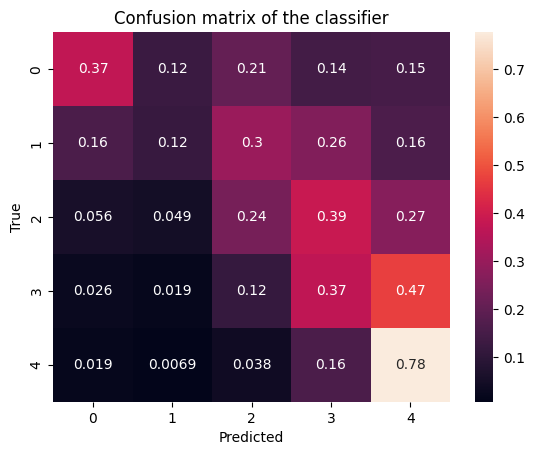

In [22]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [23]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)